In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)


# subset our PV target to common timeframe
target = gsp["generation_mw"].where((gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), drop=True)
target = target.isel(gsp_id=0)


# NWP data transformation 
X = nwp.isel(step=0)
# rechunk
X = X.chunk({"init_time": 1, "variable": 1})
# take geospatial mean
X = X.mean(dim=["x", "y"])


# interpolate to 1/2 hourly (same resolution as PV target)
new_times = gsp.coords["datetime_gmt"].values
X = X.interp(init_time=new_times, method="cubic")

# reindex our features to closest target
X = X.sel(init_time=target.coords["datetime_gmt"].values, method="ffill")

assert (target["datetime_gmt"].values == X["init_time"].values).all()

In [3]:
X

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 32527)
Coordinates:
    step       timedelta64[ns] 00:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
Data variables:
    UKV        (variable, init_time) float32 dask.array<chunksize=(1, 32527), meta=np.ndarray>

In [4]:
from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )

In [5]:
datetime_features = trigonometric_datetime_transformation(X["init_time"])

In [7]:
# concat the nwp and datetime features together into one design matrix.
X.to_array()

<xarray.DataArray (variable: 17, init_time: 32527)>
dask.array<stack, shape=(1, 17, 32527), dtype=float32, chunksize=(1, 1, 32527), chunktype=numpy.ndarray>
Coordinates:
    step       timedelta64[ns] 00:00:00
  * variable   (variable) object 'UKV'
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00

In [8]:
_X = X.to_array().as_numpy()
_X = _X.values.reshape(_X.shape[1], _X.shape[2]).T
_X = np.concatenate((_X, datetime_features), axis=1)

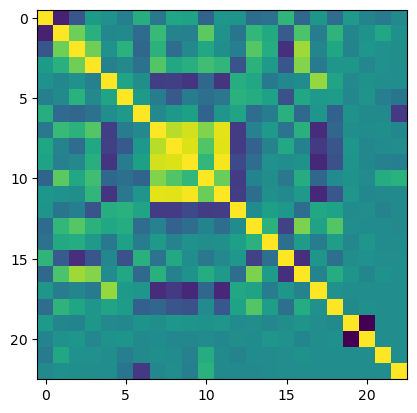

In [24]:
plt.imshow(pd.DataFrame(_X).corr())

In [34]:
TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]

design = pd.DataFrame(data=_X, index=X.coords["init_time"].values, columns=list(X.coords["variable"].values) + TRIG_DATETIME_FEATURE_NAMES)
design

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,...,si10,wdir10,prmsl,prate,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR
2020-01-01 00:00:00,632.369995,70.870087,5.830586,32.670364,0.001283,-32629.847656,0.000000,316.232666,2688.883789,280.208954,...,6.881776,188.229904,102725.976562,0.000001,0.5,0.866025,0.017166,0.999853,0.000000,1.000000
2020-01-01 00:30:00,687.646356,70.705035,5.433613,32.899234,0.001283,-32629.835099,-0.193904,315.983130,2702.628593,280.190395,...,6.862118,188.265013,102700.899462,0.000001,0.5,0.866025,0.017166,0.999853,0.130526,0.991445
2020-01-01 01:00:00,742.721343,70.725728,5.330769,33.388923,0.001283,-32629.829391,-0.282043,316.028534,2710.335820,280.176540,...,6.856966,188.589163,102674.871755,0.000001,0.5,0.866025,0.017166,0.999853,0.258819,0.965926
2020-01-01 01:30:00,797.380025,70.899727,5.482882,34.104579,0.001283,-32629.829162,-0.285568,316.322121,2712.813544,280.166897,...,6.864013,189.151146,102648.336949,0.000001,0.5,0.866025,0.017166,0.999853,0.382683,0.923880
2020-01-01 02:00:00,851.407470,71.194592,5.850780,35.011349,0.001283,-32629.833044,-0.225634,316.817136,2710.869839,280.160970,...,6.880958,189.899750,102621.738550,0.000002,0.5,0.866025,0.017166,0.999853,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 13:00:00,1506.390751,64.635937,52.425588,55.233770,0.000025,-32629.864650,116.463900,346.732082,3121.229402,284.948535,...,6.910919,221.490776,101661.084446,0.000043,-0.5,0.866025,0.136906,0.990584,-0.258819,-0.965926
2021-11-08 13:30:00,1459.914016,65.062383,53.152989,55.220780,0.000025,-32629.869164,105.952857,347.436060,3117.175423,285.026305,...,6.996771,222.303429,101641.143742,0.000041,-0.5,0.866025,0.136906,0.990584,-0.382683,-0.923880
2021-11-08 14:00:00,1404.634326,65.555342,54.093611,54.979213,0.000025,-32629.868898,89.743944,348.004202,3108.765539,285.047827,...,7.072594,222.936996,101620.714499,0.000042,-0.5,0.866025,0.136906,0.990584,-0.500000,-0.866025
2021-11-08 14:30:00,1341.477141,66.105792,55.259969,54.463322,0.000025,-32629.862260,67.237410,348.401999,3095.530420,285.003983,...,7.135707,223.324433,101600.087789,0.000046,-0.5,0.866025,0.136906,0.990584,-0.608761,-0.793353


In [35]:
y = pd.DataFrame(data=target.values, index=X.coords["init_time"].values, columns=["GSP_PV"])

In [36]:
design.shape

(32527, 23)

In [37]:
# start with a randomised train/test split before structing a time-series specific one
n = design.shape[0]
train_idx = np.random.choice(np.arange(n), int(0.8*n), replace=False)
test_idx = list(set(np.arange(n)).difference(train_idx))
X_train, y_train = design.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = design.iloc[test_idx], y.iloc[test_idx]

In [39]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

# fit a vanilla xgboost with basic hyperparameters
model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [48]:
print("Basic XGBoost Model")
print(f"MSE (training/testing): {mean_squared_error(y_train, model_xg.predict(X_train)):.3f}/{mean_squared_error(y_test, model_xg.predict(X_test)):.3f}")

Basic XGBoost Model
MSE (training/testing): 27399.154/69878.355


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

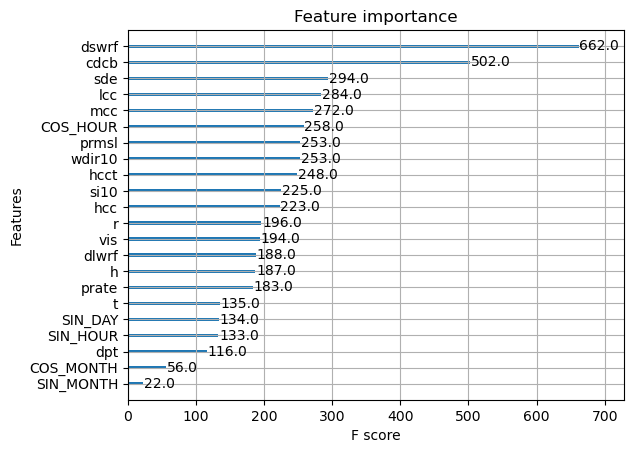

In [49]:
plot_importance(model_xg)

In [45]:
# lets so some CV
from sklearn.model_selection import GridSearchCV

# large grid search, can fine tune once we have order of magnitude correct
large_param_search = {'learning_rate': [0.01, 0.5],
                      'max_depth': [10, 50],
                      'min_child_weight': [1, 7, 20],
                      'subsample': [0.85],
                      'colsample_bytree': [0.85],
                      'n_estimators': [100, 500, 1500], 
                      }

model = XGBRegressor()
gsearch = GridSearchCV(estimator=model, param_grid=large_param_search, scoring="neg_mean_squared_error", refit=True, n_jobs=-1, cv=3, verbose=3)

In [ ]:
gsearch.fit(X_train, y_train)

In [51]:
gsearch_model = gsearch.best_estimator_
print("Tuned XGBoost Model")
print(f"MSE (training/testing): {mean_squared_error(y_train, gsearch_model.predict(X_train)):.3f}/{mean_squared_error(y_test, gsearch_model.predict(X_test)):.3f}")

Tuned XGBoost Model
MSE (training/testing): 1051.228/37345.814


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

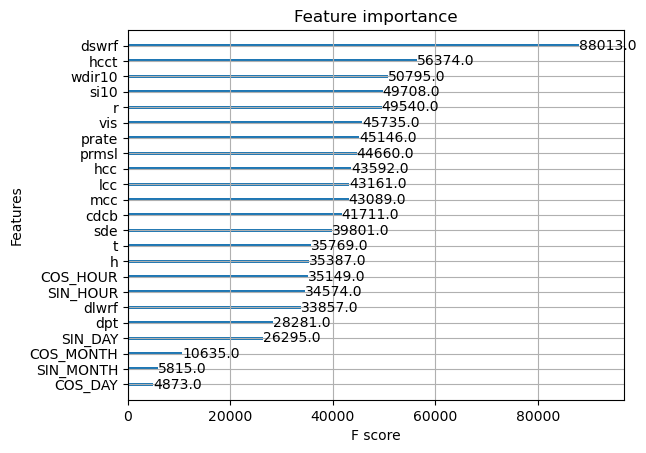

In [52]:
plot_importance(gsearch_model)

In [55]:
gsearch_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.85,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 50,
 'max_leaves': 0,
 'min_child_weight': 20,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1500,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.85,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [56]:
# fine tune the model further with narrower gridsearch

# narrow grid search, can fine tune once we have order of magnitude correct
narrow_param_search = {'learning_rate': [0.001, 0.005], #so called `eta` value
                      'max_depth': [75, 120],
                      'min_child_weight': [12, 30],
                      'subsample': [0.75],
                      'colsample_bytree': [0.85],
                      'n_estimators': [1700, 2500],
                      "gamma" : [0, 5]
                      }

model = XGBRegressor()
narrow_gsearch = GridSearchCV(estimator=model, param_grid=narrow_param_search, scoring="neg_mean_squared_error", refit=True, n_jobs=10, cv=3)

In [57]:
narrow_gsearch.fit(X_train, y_train)

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.85], 'gamma': [0, 5],
                         'learning_rate': [0.001, 0.005],
                         'max_depth': [75, 120], 'min_child_weight': [12, 30],
                         'n_estimators': [1700, 2500], 'subsample': [0.75]},
             scoring='neg_mean_squared_error')

In [58]:
best_model = narrow_gsearch.best_estimator_

In [59]:
gsearch_model = gsearch.best_estimator_
print("Final XGBoost Model")
print(f"MSE (training/testing): {mean_squared_error(y_train, best_model.predict(X_train)):.3f}/{mean_squared_error(y_test, best_model.predict(X_test)):.3f}")

Final XGBoost Model
MSE (training/testing): 501.630/38480.927


In [54]:
import pickle
f1 = "../models/20221129/xgb_base_model.pkl"
f2 = "../models/20221129/xgb_first_round_gsearch.pkl"


# save
pickle.dump(model_xg, open(f1, "wb"))
pickle.dump(gsearch_model, open(f1, "wb"))


# load
# xgb_model_loaded = pickle.load(open(file_name, "rb"))